Basado en: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py y https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpc_iris.html#sphx-glr-auto-examples-gaussian-process-plot-gpc-iris-py

En este cuaderno se va a tratar el conocido problema de clasificar flores iris según su especie: Iris setosa, Iris virginica o Iris versicolor. Este problema ya fue tratado en 1936 por Fisher en su paper ’The use of multiple measurements in taxonomic problems’. El dataset consta de
150 instancias, 50 por clase, y cada instancia incluye las siguientes características: longitud y ancho del sépalo, así como longitud y ancho del pétalo.

## 1. Análisis descriptivo del problema y análisis exploratorio de los datos a nuestra disposición.

Cargo datos y compruebo que se han guardado correctamente (150 instancias, 50 por clase)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

# Cargo los datos en la variable iris
iris = datasets.load_iris()

# Ver el tamaño de los datos
print("Tamaño de los datos:", iris.data.shape)

# Ver el tamaño de las etiquetas
print("Tamaño de las etiquetas:", iris.target.shape)

# Número de instancias por clase
print("\nNúmero de instancias por clase:")
for i in range(len(iris.target_names)):
    instances = np.sum(iris.target == i)
    print(f"Clase {i}: {instances} instancias")




Tamaño de los datos: (150, 4)
Tamaño de las etiquetas: (150,)

Número de instancias por clase:
Clase 0: 50 instancias
Clase 1: 50 instancias
Clase 2: 50 instancias


Voy a dividir los datos en test y train de forma estratificada

In [3]:
from sklearn.model_selection import train_test_split

# Separar datos en características (X) y etiquetas (y)
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Realizar la separación estratificada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Imprimir las formas de los conjuntos de entrenamiento y prueba
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)


Forma de X_train: (112, 4)
Forma de X_test: (38, 4)
Forma de y_train: (112,)
Forma de y_test: (38,)


## 2. Preprocesado de datos

Realizo un resumen estadístico de los datos de train (no cojo todos los datos ya que se podría considerar data snooping):

In [4]:
import pandas as pd

# Convertir los datos de entrenamiento en un DataFrame de Pandas
df_train = pd.DataFrame(data=X_train, columns=iris.feature_names)
df_train['target'] = y_train

# Resumen estadístico de los datos de entrenamiento
summary_stats_train = df_train.describe()
print("\nResumen estadístico de los datos de entrenamiento:")
print(summary_stats_train)


Resumen estadístico de los datos de entrenamiento:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         112.000000        112.000000         112.000000   
mean            5.877679          3.066071           3.764286   
std             0.853262          0.443685           1.783753   
min             4.300000          2.000000           1.100000   
25%             5.100000          2.800000           1.575000   
50%             5.800000          3.000000           4.300000   
75%             6.400000          3.325000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        112.000000  112.000000  
mean           1.193750    0.991071  
std            0.770314    0.821946  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.825000    2.000000  
max            2.500000    2.000000  


Voy a realizar gráficos de dispersión para ver como se distribuyen las clases según el sépalo y pétalo:

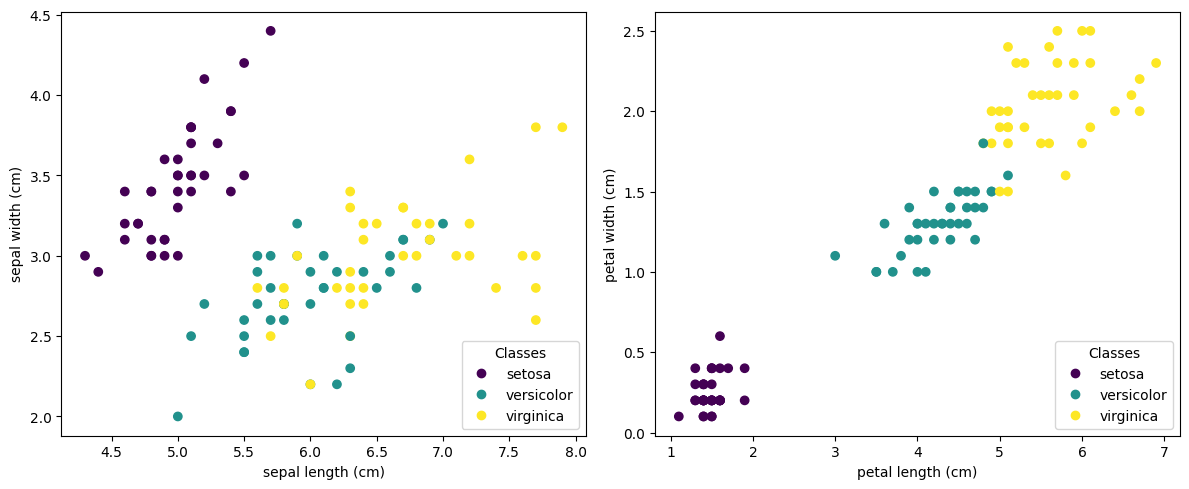

In [5]:
# Crear gráficos solo con los datos de entrenamiento
_, axs = plt.subplots(1, 2, figsize=(12, 5))  # Crear una figura con dos subgráficos en una fila

# Primer subgráfico
scatter1 = axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train)
axs[0].set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = axs[0].legend(scatter1.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")

# Segundo subgráfico
scatter2 = axs[1].scatter(X_train[:, 2], X_train[:, 3], c=y_train)
axs[1].set(xlabel=iris.feature_names[2], ylabel=iris.feature_names[3])
_ = axs[1].legend(scatter2.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")

plt.tight_layout()  # Ajustar automáticamente los subgráficos para evitar solapamientos
plt.show()

Ahora realizo boxplots de las 4 características, pero no se detectan apenas otliers:

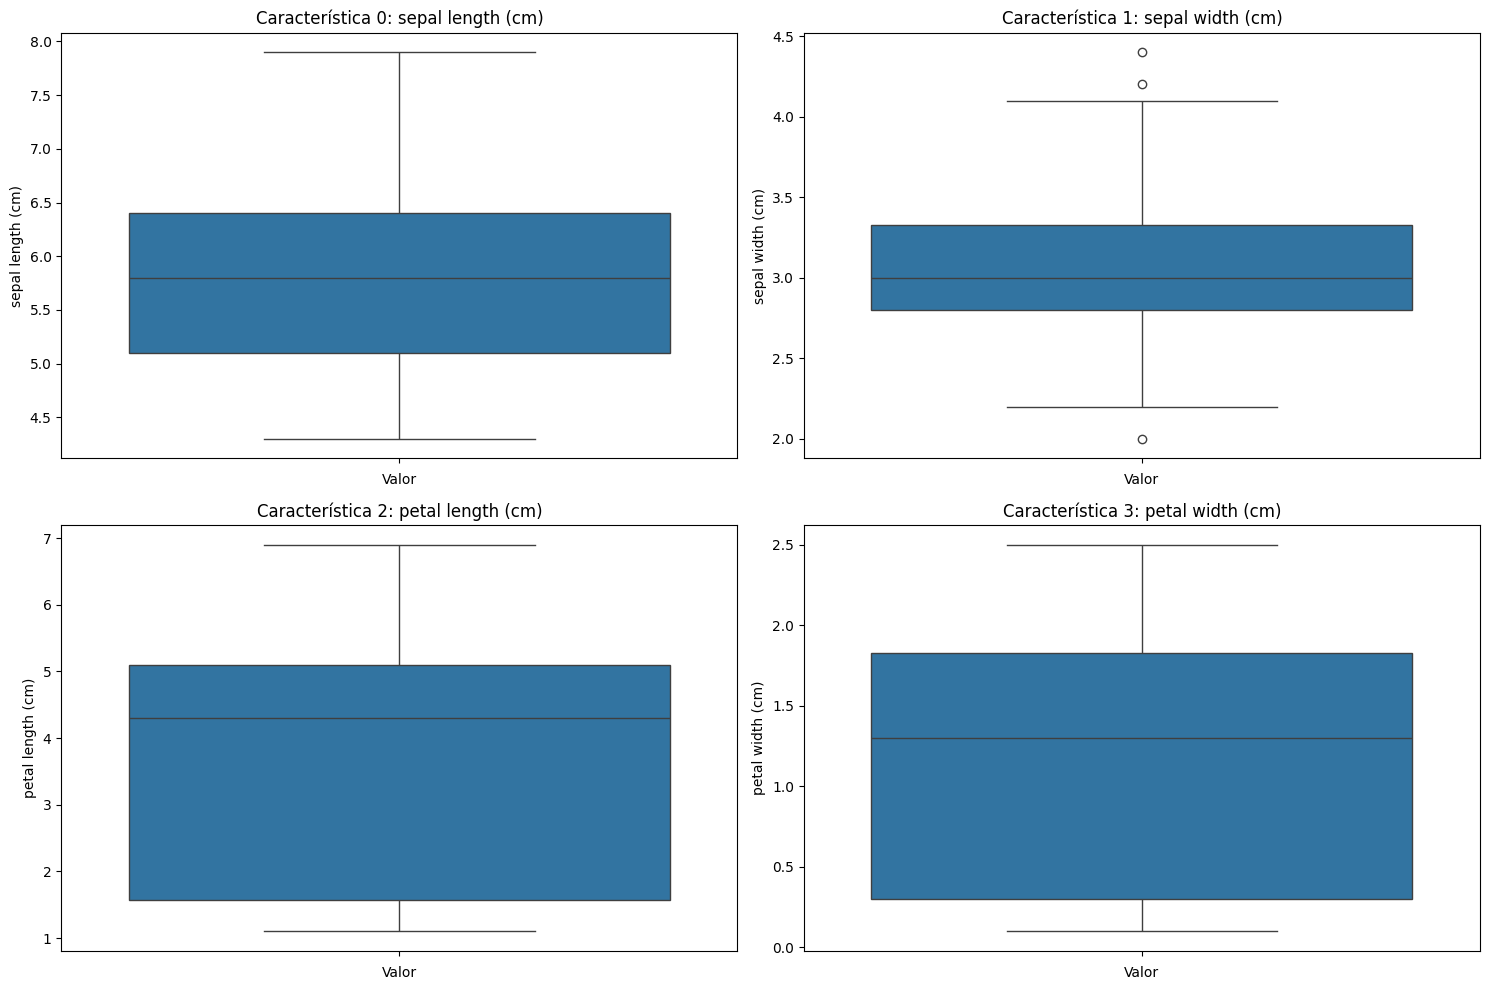

In [6]:
import seaborn as sns

## Crear un DataFrame de Pandas solo con los datos de entrenamiento
df_train = pd.DataFrame(data=X_train, columns=feature_names)

# Configurar el tamaño de la figura y los subplots
plt.figure(figsize=(15, 10))
for i in range(df_train.shape[1]):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df_train.iloc[:, i])
    plt.title("Característica " + str(i) + ": " + feature_names[i])
    plt.xlabel("Valor")

plt.tight_layout()
plt.show()

Antes de aplicar PCA se deben normalizar los datos:

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Primero normalizo los datos con MinMaxScaler
scaler = MinMaxScaler()
X_training_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
import numpy as np

# Asegurarse de que X_training_scaled sea un numpy array
X_training_scaled = np.array(X_training_scaled)

# Calcula el rango intercuartílico (IQR) para cada característica en el conjunto de entrenamiento
Q1 = np.percentile(X_training_scaled, 25, axis=0)
Q3 = np.percentile(X_training_scaled, 75, axis=0)
IQR = Q3 - Q1

# Identifica los valores atípicos para cada característica
outliers = (X_training_scaled < (Q1 - 1.5 * IQR)) | (X_training_scaled > (Q3 + 1.5 * IQR))

# Cuenta el número de valores atípicos por característica
outliers_count = np.sum(outliers, axis=0)

print("Número de valores atípicos por característica:")
print(outliers_count)


Número de valores atípicos por característica:
[0 3 0 0]


In [9]:
# Encuentra los índices de los valores atípicos en la segunda característica
outlier_indices = np.where(outliers[:, 1])[0]

# Eliminar los outliers
X_training_scaled_cleaned = np.delete(X_training_scaled, outlier_indices, axis=0)
y_train_cleaned = np.delete(y_train, outlier_indices, axis=0)

print(f"Shape original de X_training_scaled: {X_training_scaled.shape}")
print(f"Shape original de y_train: {y_train.shape}")
print(f"Shape de X_training_scaled sin outliers: {X_training_scaled_cleaned.shape}")
print(f"Shape de y_train sin outliers: {y_train_cleaned.shape}")

Shape original de X_training_scaled: (112, 4)
Shape original de y_train: (112,)
Shape de X_training_scaled sin outliers: (109, 4)
Shape de y_train sin outliers: (109,)


In [10]:
X_training_scaled = X_training_scaled_cleaned
y_train = y_train_cleaned

**PCA:**

En el ámbito del Machine Learning, el PCA se utiliza como una técnica de preprocesamiento de datos para reducir la complejidad de los modelos y mejorar su rendimiento, especialmente en conjuntos de datos con muchas características redundantes o irrelevantes.

Transforma un conjunto de datos con muchas variables correlacionadas en un conjunto de datos con menos variables no correlacionadas, llamadas componentes principales. Estas componentes están ordenadas por la cantidad de varianza que capturan en los datos originales. Las primeras componentes principales conservan la mayor cantidad de varianza, lo que permite resumir la información más importante del conjunto de datos.

Las componentes principales son ortogonales entre sí, lo que significa que son independientes linealmente. Esto facilita la interpretación de los patrones presentes en los datos y puede ayudar a eliminar la multicolinealidad entre las variables.

Voy a aplicar PCA para reducir a 3 componentes. Con 3 componentes ya se conserva mas del 99% de la varianza:

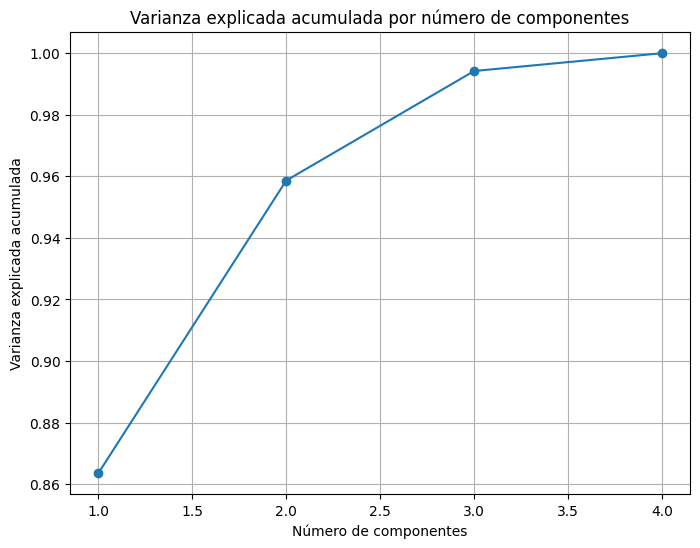

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Ajustar el modelo PCA con diferentes números de componentes
pca = PCA()
pca.fit(X_training_scaled)

# Calcular la varianza explicada acumulada
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Visualizar la varianza explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='-')
plt.title('Varianza explicada acumulada por número de componentes')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.show()


En la gráfica vemos que dos componentes principal conservaría más del 96% de la varianza explicada acumulada, lo que sugiere que podríamos optar por utilizar solo estas dos componentes. Sin embargo, dado que nuestro conjunto de datos es pequeño y con pocas características, no es estrictamente necesario reducir aún más la dimensionalidad. No tendremos problemas por un exceso de cantidad de datos.

Además, he probado a hacerlo y los resultados empeoran ligeramente.

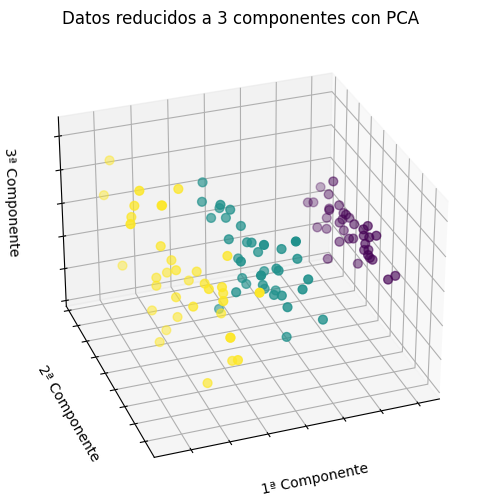

In [12]:
import mpl_toolkits.mplot3d
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

#PCA
pca = PCA(n_components=3)  # Especifica el número de componentes principales deseados

X_train_reduced = pca.fit_transform(X_training_scaled)
X_test_reduced = pca.transform(X_test_scaled)

ax.scatter(
    X_train_reduced[:, 0],
    X_train_reduced[:, 1],
    X_train_reduced[:, 2],
    c=y_train,
    s=40,
)

ax.set_title("Datos reducidos a 3 componentes con PCA")
ax.set_xlabel("1ª Componente")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2ª Componente")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3ª Componente")
ax.zaxis.set_ticklabels([])

plt.show()

## 3. Definición del protocolo de validación experimental

Voy a utilizar las mismas métricas que en el problema anterior: Accuracy y F1-Score.

**Accuracy** (Exactitud):

  La exactitud indica la proporción de predicciones correctas realizadas por el modelo sobre el total de predicciones. Es una medida simple pero importante, ya que proporciona una visión general del rendimiento del modelo. Sin embargo, no distingue entre los diferentes tipos de errores que el modelo puede cometer

  Cabe destacar que puede ser engañosa en casos de conjuntos de datos desbalanceados, donde una clase puede dominar en términos de frecuencia (no es nuestro caso).


**F1-score**:

El f1-score es una métrica que combina la precisión y el recall (proporción de verdaderos positivos frente a falsos negativos) en una sola medida. Es especialmente útil en problemas de clasificación donde las clases están desbalanceadas.

Se calcula como la media armónica entre precisión y recall, donde precisión es la proporción de verdaderos positivos respecto a todos los casos positivos predichos, y recall es la proporción de verdaderos positivos respecto a todos los casos positivos reales.

El f1-score alcanza su mejor valor en 1 y su peor valor en 0. Un f1-score alto indica un buen equilibrio entre precisión y recall, mientras que un valor bajo puede indicar problemas en el modelo, como desequilibrio de clases o errores en la clasificación.

## 4. Modelos de Aprendizaje Automático

Los tres modelos que voy a utilizar serán:
- Procesos Gaussianos

- KNN

- Support Vector Machines

Para este problema probaré la clase GaussianProcessClassifier con dos kernels distintos:
  - RBF isotrópico.
  - RBF anisotrópico.

**KNN**

Tiene un funcionamiento sencillo pero bastante efectivo. En el entrenamiento, el algoritmo simplemente almacena todos los puntos de datos y sus respectivas etiquetas en el espacio de características y cuando se realiza una predicción para un nuevo punto de datos, el algoritmo busca los k puntos más cercanos a ese punto en el espacio de características. La cercanía se determina generalmente mediante una medida de distancia, como la distancia euclidiana.

Para la clasificación, el algoritmo asigna la etiqueta más frecuente entre los k vecinos más cercanos al nuevo punto como su etiqueta de predicción.

**Support Vector Machines (SVM)**



SVM es un modelo para problemas de aprendizaje automático que durante el entrenamiento busca encontrar el hiperplano que separe mejor las clases en el espacio de características, es decir, aquel que maximiza la distancia entre el hiperplano y los puntos de datos más cercanos de cada clase. Estos puntos más cercanos son comúnmente conocidos como vectores de soporte, de ahí el nombre del modelo. A la hora de realizar la predicción, el modelo SVM asignará la etiqueta dependiendo del lado del hiperplano en el que se encuentre el nuevo punto. En los casos en que los datos no son linealmente separables, SVM utiliza el ya estudiado kernel trick. También hay que destacar que SVM es sensible a la escala de las características y que puede terner un alto coste computacional cuando se trabaje en grandes conjuntos de datos.


En problemas de clasificación multiclase, como es nuestro caso (Iris setosa, Iris virginica e Iris versicolor), SVM se puede adaptar mediante estrategias como "one vs one" y "one vs rest". De forma predeterminada, la clase SVC de Scikit Learn emplea la estrategia "one vs one". Supongamos que disponemos de n clases. Entonces, con esta estrategia el algoritmo entrena un clasificador SVM para cada par de clases, resultando en $n(n−1)/2n(n−1)/2$ clasificadores. Para una nueva muestra, se realiza una votación entre todos los clasificadores para determinar la clase final. En la estrategia "one-vs-rest", el algoritmo entrena $n$ clasificadores, un clasificador SVM para cada una de las clases vs todas las demás clases. Finalmente, la clase que obtuviese la mayor puntuación es la que el modelo predice como solución.




## 5. Selección de hiperparámetros y ejecución.

### Procesos Gaussianos (kernel RBF isotrópico)

Para Procesos Gaussianos no he hecho selección de hiperparámetros explícitamente, ya que la búsqueda de los mejores hiperparámetros para el 'kernel' la realiza el propio método 'fit'.

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, f1_score

# Inicializar el modelo de procesos gaussianos con kernel isotrópico
kernel_iso = 1.0 * RBF([1.0])
gpc_iso = GaussianProcessClassifier(kernel=kernel_iso)

# Crear el objeto StratifiedKFold con 5 particiones
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el accuracy usando validación cruzada estratificada en el conjunto de entrenamiento
accuracy_PG_iso_training = cross_val_score(gpc_iso, X_train_reduced, y_train, cv=stratified_kf, scoring='accuracy')
accuracy_PG_iso_training = accuracy_PG_iso_training.mean()
print("Accuracy en entrenamiento (validación cruzada):", accuracy_PG_iso_training)

# Calcular el F1-score usando validación cruzada en el conjunto de entrenamiento
f1_PG_iso_training = cross_val_score(gpc_iso, X_train_reduced, y_train, cv=stratified_kf, scoring='f1_macro')
f1_PG_iso_training = f1_PG_iso_training.mean()
print("F1-score en entrenamiento (validación cruzada):", f1_PG_iso_training)

# Entrenar el modelo en el conjunto de entrenamiento
gpc_iso.fit(X_train_reduced, y_train)

# Acceder a los hiperparámetros del kernel
kernel_params = gpc_iso.kernel_
print("Hiperparámetros del kernel después del entrenamiento:", kernel_params)

# Realizar predicciones en el conjunto de prueba
y_pred = gpc_iso.predict(X_test_reduced)

# Calcular la precisión del modelo
accuracy_PG_iso_test = accuracy_score(y_test, y_pred)
print("Precisión del modelo de procesos gaussianos (test):", accuracy_PG_iso_test)

# Calcular el F1-score del modelo
f1_PG_iso_test = f1_score(y_test, y_pred, average='macro')
print("F1-score del modelo de procesos gaussianos (test):", f1_PG_iso_test)



Accuracy en entrenamiento (validación cruzada): 0.9636363636363636
F1-score en entrenamiento (validación cruzada): 0.9636813186813187
Hiperparámetros del kernel después del entrenamiento: CompoundKernel(7.29, -0.0194, 5.22, -0.779, 6.27, -0.221)
Precisión del modelo de procesos gaussianos (test): 0.9473684210526315
F1-score del modelo de procesos gaussianos (test): 0.9487179487179488


Curvas de aprendizaje:

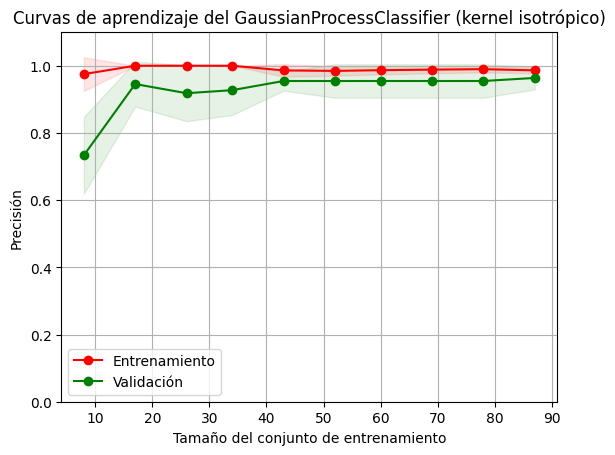

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.gaussian_process import GaussianProcessClassifier

# Generar las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    gpc_iso, X_train_reduced, y_train, cv=stratified_kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calcular los promedios y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del GaussianProcessClassifier (kernel isotrópico)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.ylim(0.0, 1.1)
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best")
plt.show()

Kernel tras el entrenamiento:

In [15]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import CompoundKernel

# Acceder al kernel compuesto
compound_kernel = gpc_iso.kernel_

# Verificar si es un CompoundKernel
if isinstance(compound_kernel, CompoundKernel):
    # Acceder a los componentes del CompoundKernel
    kernels = compound_kernel.kernels

    # Iterar sobre los kernels y mostrar cada uno
    print("Componentes del CompoundKernel:")
    for idx, kernel in enumerate(kernels):
        print(f"Kernel {idx + 1}: {kernel}")
else:
    print("El kernel no es un CompoundKernel.")

Componentes del CompoundKernel:
Kernel 1: 38.2**2 * RBF(length_scale=0.981)
Kernel 2: 13.6**2 * RBF(length_scale=0.459)
Kernel 3: 22.9**2 * RBF(length_scale=0.801)


Probabilidades que se predicen para las primeras instancias de test:

In [16]:
# Predecir probabilidades
probabilidades = gpc_iso.predict_proba(X_test_reduced)

# Mostrar algunas probabilidades y sus intervalos de confianza
for i in range(10):
    print(f"Predicción para la muestra {i}. Clase real {y_test[i]}")
    for clase, prob in enumerate(probabilidades[i]):
        print(f"Clase {clase}: Probabilidad {prob:.3f}")
    print()


Predicción para la muestra 0. Clase real 0
Clase 0: Probabilidad 0.766
Clase 1: Probabilidad 0.094
Clase 2: Probabilidad 0.140

Predicción para la muestra 1. Clase real 1
Clase 0: Probabilidad 0.197
Clase 1: Probabilidad 0.728
Clase 2: Probabilidad 0.075

Predicción para la muestra 2. Clase real 1
Clase 0: Probabilidad 0.126
Clase 1: Probabilidad 0.853
Clase 2: Probabilidad 0.021

Predicción para la muestra 3. Clase real 1
Clase 0: Probabilidad 0.131
Clase 1: Probabilidad 0.799
Clase 2: Probabilidad 0.071

Predicción para la muestra 4. Clase real 0
Clase 0: Probabilidad 0.733
Clase 1: Probabilidad 0.127
Clase 2: Probabilidad 0.140

Predicción para la muestra 5. Clase real 1
Clase 0: Probabilidad 0.215
Clase 1: Probabilidad 0.741
Clase 2: Probabilidad 0.044

Predicción para la muestra 6. Clase real 2
Clase 0: Probabilidad 0.127
Clase 1: Probabilidad 0.408
Clase 2: Probabilidad 0.465

Predicción para la muestra 7. Clase real 2
Clase 0: Probabilidad 0.197
Clase 1: Probabilidad 0.026
Clase

### Procesos Gaussianos (kernel RBF anisotrópico)

In [17]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, f1_score

# Inicializar el modelo de procesos gaussianos con kernel anisotrópico
kernel_ani = 1.0 * RBF([1.0, 1.0, 1.0])       # Hay 3 características
gpc_ani = GaussianProcessClassifier(kernel=kernel_ani)

# Crear el objeto StratifiedKFold con 5 particiones
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el accuracy usando validación cruzada estratificada en el conjunto de entrenamiento
accuracy_PG_ani_training = cross_val_score(gpc_ani, X_train_reduced, y_train, cv=stratified_kf, scoring='accuracy')
accuracy_PG_ani_training = accuracy_PG_ani_training.mean()
print("Accuracy en entrenamiento (validación cruzada):", accuracy_PG_ani_training)

# Calcular el F1-score usando validación cruzada en el conjunto de entrenamiento
f1_PG_ani_training = cross_val_score(gpc_ani, X_train_reduced, y_train, cv=stratified_kf, scoring='f1_macro')
f1_PG_ani_training = f1_PG_ani_training.mean()
print("F1-score en entrenamiento (validación cruzada):", f1_PG_ani_training)

# Entrenar el modelo en el conjunto de entrenamiento
gpc_ani.fit(X_train_reduced, y_train)

# Acceder a los hiperparámetros del kernel
kernel_params = gpc_ani.kernel_
print("Hiperparámetros del kernel después del entrenamiento:", kernel_params)

# Realizar predicciones en el conjunto de prueba
y_pred_ani = gpc_ani.predict(X_test_reduced)

# Calcular la precisión del modelo
accuracy_PG_ani_test = accuracy_score(y_test, y_pred_ani)
print("Precisión del modelo de procesos gaussianos (test):", accuracy_PG_ani_test)

# Calcular el F1-score del modelo
f1_PG_ani_test = f1_score(y_test, y_pred_ani, average='macro')
print("F1-score del modelo de procesos gaussianos (test):", f1_PG_ani_test)



Accuracy en entrenamiento (validación cruzada): 0.9636363636363636
F1-score en entrenamiento (validación cruzada): 0.9635997988939167
Hiperparámetros del kernel después del entrenamiento: CompoundKernel(7.87, -0.248, 9.73, 7.14, 6.43, -1.05, 0.579, 1.02, 7.11, -0.598, 0.927, 1.23)
Precisión del modelo de procesos gaussianos (test): 0.9210526315789473
F1-score del modelo de procesos gaussianos (test): 0.9229629629629629


Curvas de aprendizaje:

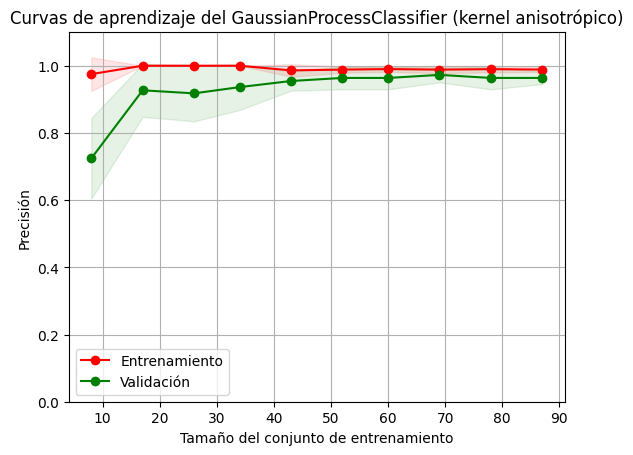

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.gaussian_process import GaussianProcessClassifier

# Generar las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    gpc_ani, X_train_reduced, y_train, cv=stratified_kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calcular los promedios y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del GaussianProcessClassifier (kernel anisotrópico)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.ylim(0.0, 1.1)
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best")
plt.show()

Kernel resultante tras el entrenamiento:

In [19]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import CompoundKernel

# Acceder al kernel compuesto
compound_kernel = gpc_ani.kernel_

# Verificar si es un CompoundKernel
if isinstance(compound_kernel, CompoundKernel):
    # Acceder a los componentes del CompoundKernel
    kernels = compound_kernel.kernels

    # Iterar sobre los kernels y mostrar cada uno
    print("Componentes del CompoundKernel:")
    for idx, kernel in enumerate(kernels):
        print(f"Kernel {idx + 1}: {kernel}")
else:
    print("El kernel no es un CompoundKernel.")

Componentes del CompoundKernel:
Kernel 1: 51.1**2 * RBF(length_scale=[0.78, 1.67e+04, 1.26e+03])
Kernel 2: 24.9**2 * RBF(length_scale=[0.348, 1.78, 2.78])
Kernel 3: 34.9**2 * RBF(length_scale=[0.55, 2.53, 3.42])


Probabilidades que se predicen para las primeras instancias de test:

In [20]:
# Predecir probabilidades
probabilidades = gpc_ani.predict_proba(X_test_reduced)

# Mostrar algunas probabilidades y sus intervalos de confianza
for i in range(10):
    print(f"Predicción para la muestra {i}. Clase real {y_test[i]}")
    for clase, prob in enumerate(probabilidades[i]):
        print(f"Clase {clase}: Probabilidad {prob:.3f}")
    print()


Predicción para la muestra 0. Clase real 0
Clase 0: Probabilidad 0.596
Clase 1: Probabilidad 0.152
Clase 2: Probabilidad 0.252

Predicción para la muestra 1. Clase real 1
Clase 0: Probabilidad 0.193
Clase 1: Probabilidad 0.764
Clase 2: Probabilidad 0.043

Predicción para la muestra 2. Clase real 1
Clase 0: Probabilidad 0.172
Clase 1: Probabilidad 0.786
Clase 2: Probabilidad 0.042

Predicción para la muestra 3. Clase real 1
Clase 0: Probabilidad 0.173
Clase 1: Probabilidad 0.765
Clase 2: Probabilidad 0.062

Predicción para la muestra 4. Clase real 0
Clase 0: Probabilidad 0.599
Clase 1: Probabilidad 0.150
Clase 2: Probabilidad 0.251

Predicción para la muestra 5. Clase real 1
Clase 0: Probabilidad 0.183
Clase 1: Probabilidad 0.784
Clase 2: Probabilidad 0.033

Predicción para la muestra 6. Clase real 2
Clase 0: Probabilidad 0.206
Clase 1: Probabilidad 0.279
Clase 2: Probabilidad 0.515

Predicción para la muestra 7. Clase real 2
Clase 0: Probabilidad 0.237
Clase 1: Probabilidad 0.083
Clase

Malla con los colores de las predicciones de los dos modelos GPC:

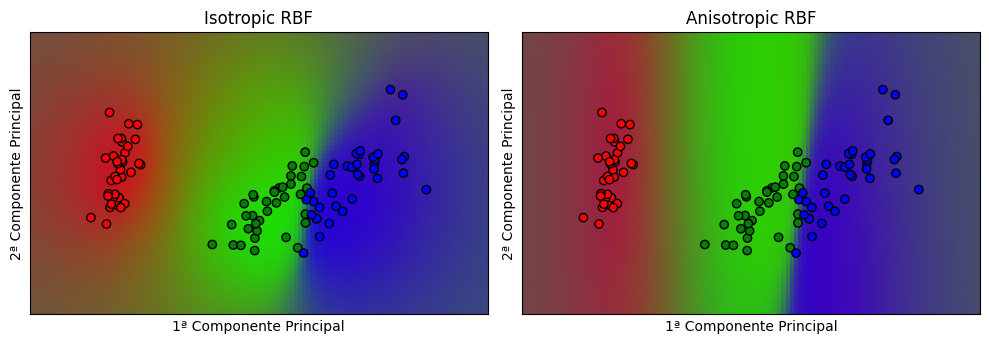

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Usar solo las primeras dos componentes principales para la clasificación y visualización en 2D
X_train_reduced_2D = X_train_reduced[:, :2]

h = 0.02  # Tamaño del paso en la malla

# Clasificadores con kernel RBF isotrópico y anisotrópico
kernel_isotropic = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel_isotropic).fit(X_train_reduced_2D, y_train)
kernel_anisotropic = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel_anisotropic).fit(X_train_reduced_2D, y_train)

# Crear una malla para graficar con límites más ajustados
x_min, x_max = X_train_reduced_2D[:, 0].min() - 0.3, X_train_reduced_2D[:, 0].max() + 0.3
y_min, y_max = X_train_reduced_2D[:, 1].min() - 0.3, X_train_reduced_2D[:, 1].max() + 0.3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Graficar las probabilidades predichas
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Colocar el resultado en un gráfico de colores
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Graficar también los puntos de entrenamiento
    plt.scatter(X_train_reduced_2D[:, 0], X_train_reduced_2D[:, 1], c=np.array(["r", "g", "b"])[y_train], edgecolors=(0, 0, 0))
    plt.xlabel("1ª Componente Principal")
    plt.ylabel("2ª Componente Principal")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(
        "%s" % (titles[i])
    )

plt.tight_layout()
plt.show()


Dibujar regiones y fronteras de decisión:

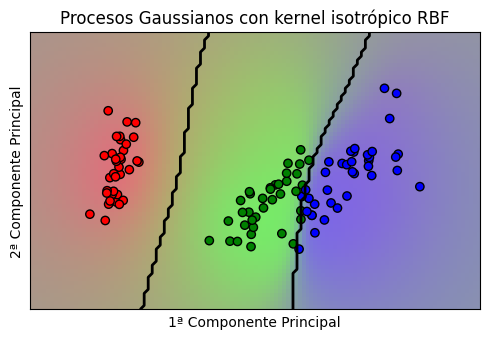

In [22]:

# Clasificador con kernel RBF isotrópico
kernel_isotropic = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel_isotropic).fit(X_train_reduced_2D, y_train)

# Crear una malla para graficar con límites más ajustados
x_min, x_max = X_train_reduced_2D[:, 0].min() - 0.3, X_train_reduced_2D[:, 0].max() + 0.3
y_min, y_max = X_train_reduced_2D[:, 1].min() - 0.3, X_train_reduced_2D[:, 1].max() + 0.3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

plt.figure(figsize=(5, 5))

# Graficar las probabilidades predichas
Z = gpc_rbf_isotropic.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape((xx.shape[0], xx.shape[1], -1))

# Obtener las predicciones de clase
Z_class = gpc_rbf_isotropic.predict(np.c_[xx.ravel(), yy.ravel()])
Z_class = Z_class.reshape(xx.shape)

# Colocar el resultado en un gráfico de colores
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower", alpha=0.6, cmap=plt.cm.coolwarm)

# Añadir las fronteras de decisión
plt.contour(xx, yy, Z_class, levels=[0.5, 1.5, 2.5], linewidths=2, colors='k')

# Graficar también los puntos de entrenamiento
plt.scatter(X_train_reduced_2D[:, 0], X_train_reduced_2D[:, 1], c=np.array(["r", "g", "b"])[y_train], edgecolors=(0, 0, 0))
plt.xlabel("1ª Componente Principal")
plt.ylabel("2ª Componente Principal")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("Procesos Gaussianos con kernel isotrópico RBF")

plt.tight_layout()
plt.show()

Mostrando los 3 primeros puntos de test, utilzados en la memoria del TFG:

<ipython-input-23-281dec7e6541>:39: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_reduced_2D[:3, 0], X_test_reduced_2D[:3, 1], c=np.array(["y", "c", "m"])[y_test[:3]], edgecolors='k', marker='x', s=100, label='Test')
<ipython-input-23-281dec7e6541>:39: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_reduced_2D[:3, 0], X_test_reduced_2D[:3, 1], c=np.array(["y", "c", "m"])[y_test[:3]], edgecolors='k', marker='x', s=100, label='Test')


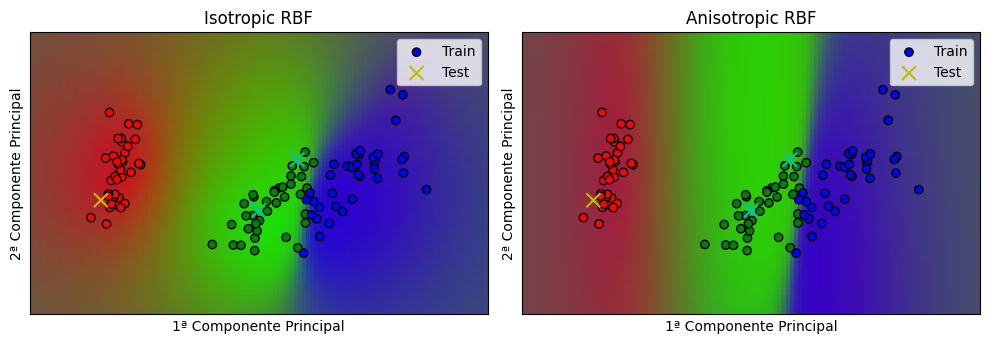

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Usar solo las primeras dos componentes principales para la clasificación y visualización en 2D
X_train_reduced_2D = X_train_reduced[:, :2]
X_test_reduced_2D = X_test_reduced[:, :2]  # Reducir el conjunto de prueba a 2D

h = 0.02  # Tamaño del paso en la malla

# Clasificadores con kernel RBF isotrópico y anisotrópico
kernel_isotropic = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel_isotropic).fit(X_train_reduced_2D, y_train)
kernel_anisotropic = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel_anisotropic).fit(X_train_reduced_2D, y_train)

# Crear una malla para graficar con límites más ajustados
x_min, x_max = X_train_reduced_2D[:, 0].min() - 0.3, X_train_reduced_2D[:, 0].max() + 0.3
y_min, y_max = X_train_reduced_2D[:, 1].min() - 0.3, X_train_reduced_2D[:, 1].max() + 0.3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Graficar las probabilidades predichas
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Colocar el resultado en un gráfico de colores
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Graficar también los puntos de entrenamiento
    plt.scatter(X_train_reduced_2D[:, 0], X_train_reduced_2D[:, 1], c=np.array(["r", "g", "b"])[y_train], edgecolors=(0, 0, 0), label='Train')

    # Graficar las primeras tres instancias del conjunto de prueba con colores diferentes
    plt.scatter(X_test_reduced_2D[:3, 0], X_test_reduced_2D[:3, 1], c=np.array(["y", "c", "m"])[y_test[:3]], edgecolors='k', marker='x', s=100, label='Test')

    plt.xlabel("1ª Componente Principal")
    plt.ylabel("2ª Componente Principal")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    plt.legend()

plt.tight_layout()
plt.show()


### SVM

Primero se determinan los hiperparámetros a usar.

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'C': [0.1, 1, 10, 100],               # Parámetro de regularización
    'gamma': [1, 0.1, 0.01, 0.001],       # Coeficiente del kernel RBF
    'kernel': ['rbf', 'linear']           # Tipo de kernel
}

# Inicializar el modelo SVM
svm = SVC()

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en la cuadrícula con los datos de entrenamiento
grid_search.fit(X_train_reduced, y_train)

# Mostrar los mejores hiperparámetros y el mejor score
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score de validación cruzada (accuracy):", grid_search.best_score_)


Mejores hiperparámetros: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Mejor score de validación cruzada (accuracy): 0.9627705627705628


In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# Inicializar el modelo SVM con los mejores hiperparámetros obtenidos
svm = SVC(
    C=1,                 # Mejor valor para el parámetro de regularización
    gamma=1,             # Mejor valor para el coeficiente del kernel
    kernel='rbf',     # Mejor tipo de kernel
    random_state=42      # Estado aleatorio para reproducibilidad (no todos los kernels soportan random_state)
)

# Crear el objeto StratifiedKFold con 5 particiones
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el accuracy usando validación cruzada en el conjunto de entrenamiento
accuracy_svm_training = cross_val_score(svm, X_train_reduced, y_train, cv=stratified_kf, scoring='accuracy')
accuracy_svm_training = accuracy_svm_training.mean()
print("Accuracy en entrenamiento (validación cruzada):", accuracy_svm_training)

# Calcular el F1-score usando validación cruzada en el conjunto de entrenamiento
f1_svm_training = cross_val_score(svm, X_train_reduced, y_train, cv=stratified_kf, scoring='f1_macro')
f1_svm_training = f1_svm_training.mean()
print("F1-score en entrenamiento (validación cruzada):", f1_svm_training)

# Entrenar el modelo en el conjunto de entrenamiento
svm.fit(X_train_reduced, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_svm = svm.predict(X_test_reduced)

# Calcular la precisión del modelo
accuracy_svm_test = accuracy_score(y_test, y_pred_svm)
print("Accuracy del modelo SVM (test):", accuracy_svm_test)

# Calcular el F1-score del modelo
f1_svm_test = f1_score(y_test, y_pred_svm, average='macro')
print("F1-score del modelo SVM (test):", f1_svm_test)


Accuracy en entrenamiento (validación cruzada): 0.9727272727272727
F1-score en entrenamiento (validación cruzada): 0.9725702075702076
Accuracy del modelo SVM (test): 0.9210526315789473
F1-score del modelo SVM (test): 0.9229629629629629


Curvas de aprendizaje:

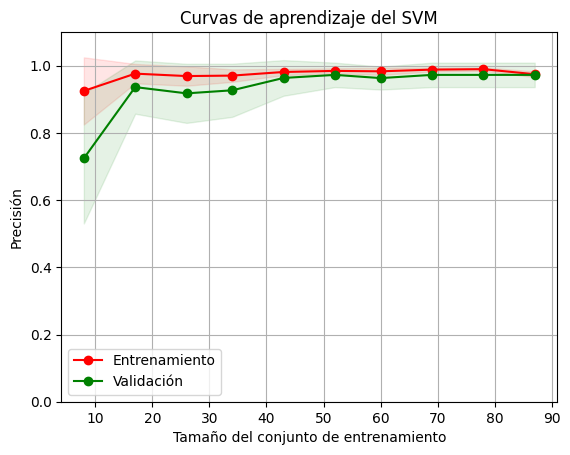

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier

# Generar las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    svm, X_train_reduced, y_train, cv=stratified_kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calcular los promedios y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del SVM")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.ylim(0.0, 1.1)
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best")
plt.show()

### KNN

Voy a determinar que parámetro de k usar en el KNN:

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir los valores de k a probar
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Inicializar el modelo KNN
knn = KNeighborsClassifier()

# Inicializar el objeto GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Entrenar el modelo utilizando GridSearchCV
grid_search.fit(X_train_reduced, y_train)

# Obtener el mejor valor de k encontrado
best_k = grid_search.best_params_['n_neighbors']
print("Mejor valor de k:", best_k)

Mejor valor de k: 11


In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Inicializar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=11)     # 11 es el mejor valor para k

# Crear el objeto StratifiedKFold con 5 particiones
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular el accuracy usando validación cruzada en el conjunto de entrenamiento
accuracy_knn_training = cross_val_score(knn, X_train_reduced, y_train, cv=stratified_kf, scoring='accuracy')
accuracy_knn_training = accuracy_knn_training.mean()
print("Accuracy en entrenamiento (validación cruzada):", accuracy_knn_training)

# Calcular el F1-score usando validación cruzada en el conjunto de entrenamiento
f1_knn_training = cross_val_score(knn, X_train_reduced, y_train, cv=5, scoring='f1_macro')
f1_knn_training = f1_knn_training.mean()
print("F1-score en entrenamiento (validación cruzada):", f1_knn_training)

# Entrenar el modelo en el conjunto de entrenamiento
knn.fit(X_train_reduced, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_knn = knn.predict(X_test_reduced)

# Calcular la precisión del modelo
accuracy_knn_test = accuracy_score(y_test, y_pred_knn)
print("Precisión del modelo KNN (test):", accuracy_knn_test)

# Calcular el F1-score del modelo
f1_knn_test = f1_score(y_test, y_pred_knn, average='macro')
print("F1-score del modelo KNN (test):", f1_knn_test)


Accuracy en entrenamiento (validación cruzada): 0.9545454545454547
F1-score en entrenamiento (validación cruzada): 0.9631746031746033
Precisión del modelo KNN (test): 0.9736842105263158
F1-score del modelo KNN (test): 0.9743209876543211


Curvas de aprendizaje:

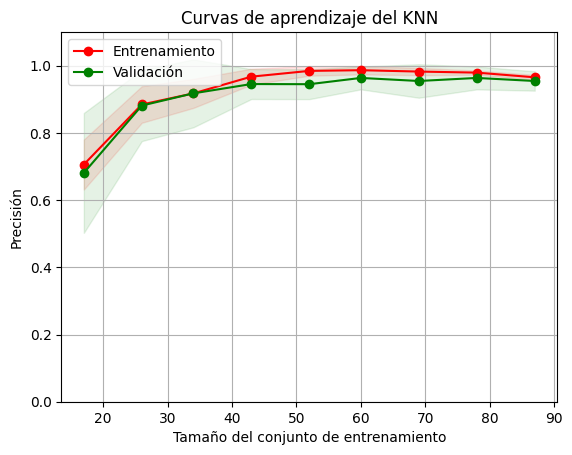

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier

# Generar las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train_reduced, y_train, cv=stratified_kf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calcular los promedios y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Visualizar las curvas de aprendizaje
plt.figure()
plt.title("Curvas de aprendizaje del KNN")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.ylim(0.0, 1.1)
plt.grid()

# Graficar el área de desviación estándar para entrenamiento y validación
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Graficar las puntuaciones medias de entrenamiento y validación
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validación")

plt.legend(loc="best")
plt.show()

## 6. Resultados y conclusiones

Los resultados obtenidos en el cross-validation son los siguientes:

In [30]:
from tabulate import tabulate

# Crear la lista de resultados
results = [
    ["Procesos Gaussianos (kernel RBF isotrópico)", accuracy_PG_iso_training, f1_PG_iso_training],
    ["Procesos Gaussianos (kernel RBF anisotrópico )", accuracy_PG_ani_training, f1_PG_ani_training],
    ["SVM", accuracy_svm_training, f1_svm_training],
    ["KNN", accuracy_knn_training, f1_knn_training]
]

# Encabezados de la tabla
headers = ["Modelo", "Accuracy en train (cross-validation)", "F1 Score en train (cross-validation)"]

# Imprimir la tabla
print(tabulate(results, headers=headers, tablefmt="pretty"))


+------------------------------------------------+--------------------------------------+--------------------------------------+
|                     Modelo                     | Accuracy en train (cross-validation) | F1 Score en train (cross-validation) |
+------------------------------------------------+--------------------------------------+--------------------------------------+
|  Procesos Gaussianos (kernel RBF isotrópico)   |          0.9636363636363636          |          0.9636813186813187          |
| Procesos Gaussianos (kernel RBF anisotrópico ) |          0.9636363636363636          |          0.9635997988939167          |
|                      SVM                       |          0.9727272727272727          |          0.9725702075702076          |
|                      KNN                       |          0.9545454545454547          |          0.9631746031746033          |
+------------------------------------------------+--------------------------------------+--------

Y en test:

In [31]:
from tabulate import tabulate

# Crear la lista de resultados
results = [
    ["Procesos Gaussianos (kernel RBF isotrópico)", accuracy_PG_iso_test, f1_PG_iso_test],
    ["Procesos Gaussianos (kernel RBF anisotrópico )", accuracy_PG_ani_test, f1_PG_ani_test],
    ["SVM", accuracy_svm_test, f1_svm_test],
    ["KNN", accuracy_knn_test, f1_knn_test]
]

# Encabezados de la tabla
headers = ["Modelo", "Accuracy (test)", "F1 Score (test)"]

# Imprimir la tabla
print(tabulate(results, headers=headers, tablefmt="pretty"))


+------------------------------------------------+--------------------+--------------------+
|                     Modelo                     |  Accuracy (test)   |  F1 Score (test)   |
+------------------------------------------------+--------------------+--------------------+
|  Procesos Gaussianos (kernel RBF isotrópico)   | 0.9473684210526315 | 0.9487179487179488 |
| Procesos Gaussianos (kernel RBF anisotrópico ) | 0.9210526315789473 | 0.9229629629629629 |
|                      SVM                       | 0.9210526315789473 | 0.9229629629629629 |
|                      KNN                       | 0.9736842105263158 | 0.9743209876543211 |
+------------------------------------------------+--------------------+--------------------+


Matrices de confusión:

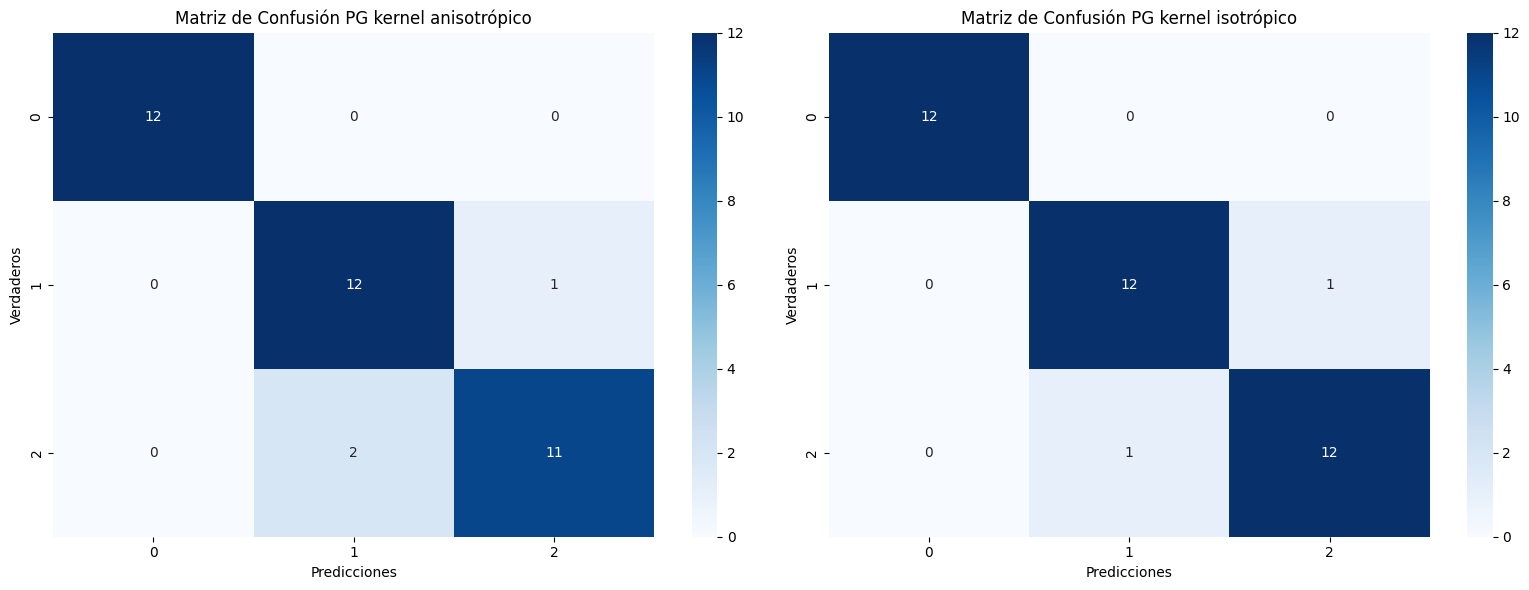

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular las matrices de confusión
conf_matrix_ani = confusion_matrix(y_test, y_pred_ani)
conf_matrix_iso = confusion_matrix(y_test, y_pred)

# Crear subplots para ambas matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión para kernel anisotrópico
sns.heatmap(conf_matrix_ani, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión PG kernel anisotrópico')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Verdaderos')

# Matriz de confusión para kernel isotrópico
sns.heatmap(conf_matrix_iso, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz de Confusión PG kernel isotrópico')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Verdaderos')

# Ajustar diseño
plt.tight_layout()
plt.show()


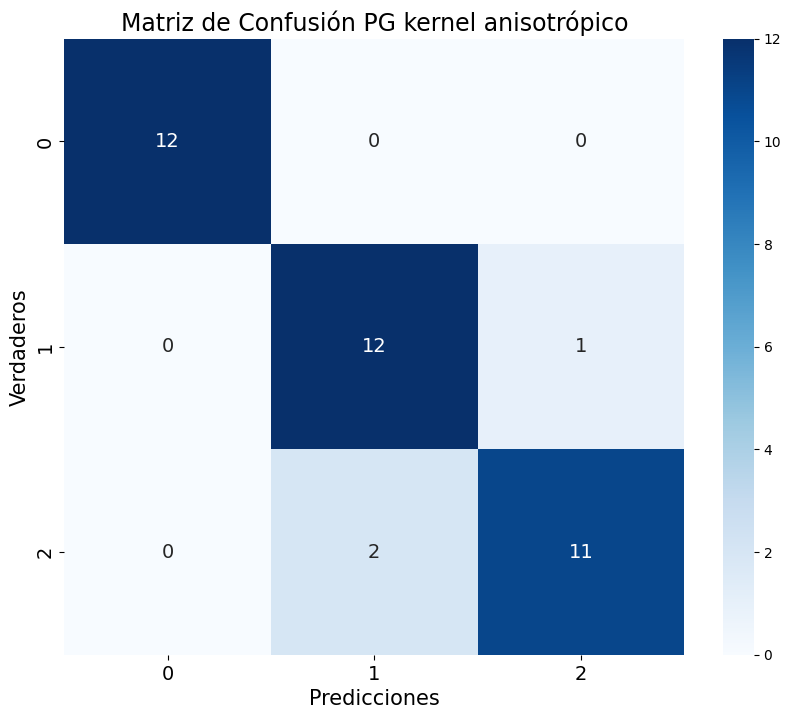

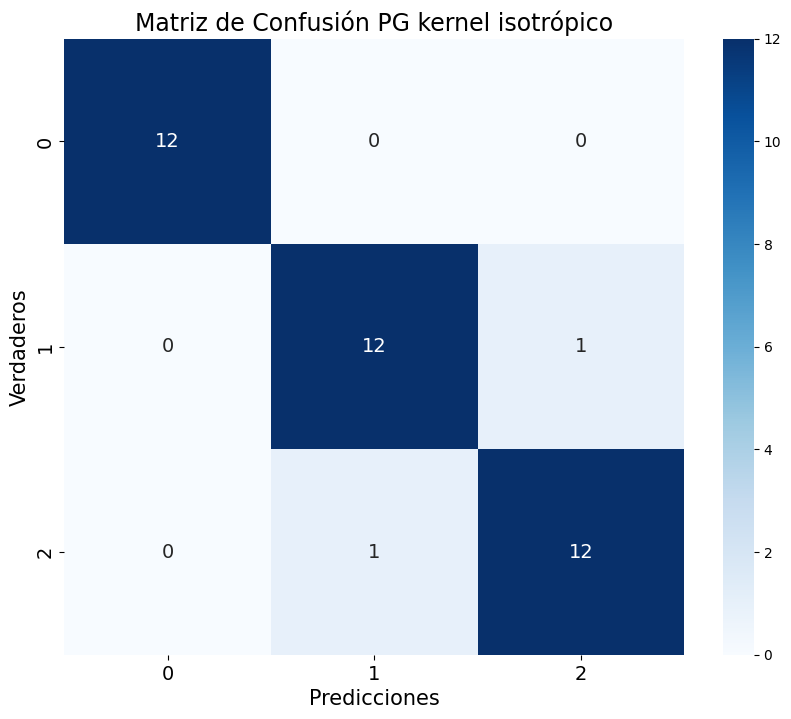

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular las matrices de confusión
conf_matrix_ani = confusion_matrix(y_test, y_pred_ani)
conf_matrix_iso = confusion_matrix(y_test, y_pred)

# Crear figura para la matriz de confusión del kernel anisotrópico
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_ani, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
plt.title('Matriz de Confusión PG kernel anisotrópico', fontsize=17)
plt.xlabel('Predicciones', fontsize=15)
plt.ylabel('Verdaderos', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Crear figura para la matriz de confusión del kernel isotrópico
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_iso, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
plt.title('Matriz de Confusión PG kernel isotrópico', fontsize=17)
plt.xlabel('Predicciones', fontsize=15)
plt.ylabel('Verdaderos', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
